https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

https://stackoverflow.com/questions/47295871/is-there-a-way-to-use-pipenv-with-jupyter-notebook


In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web

In [2]:
start_date = datetime.datetime(2010,1,1)
end_date = datetime.datetime(2019,9,1)
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()


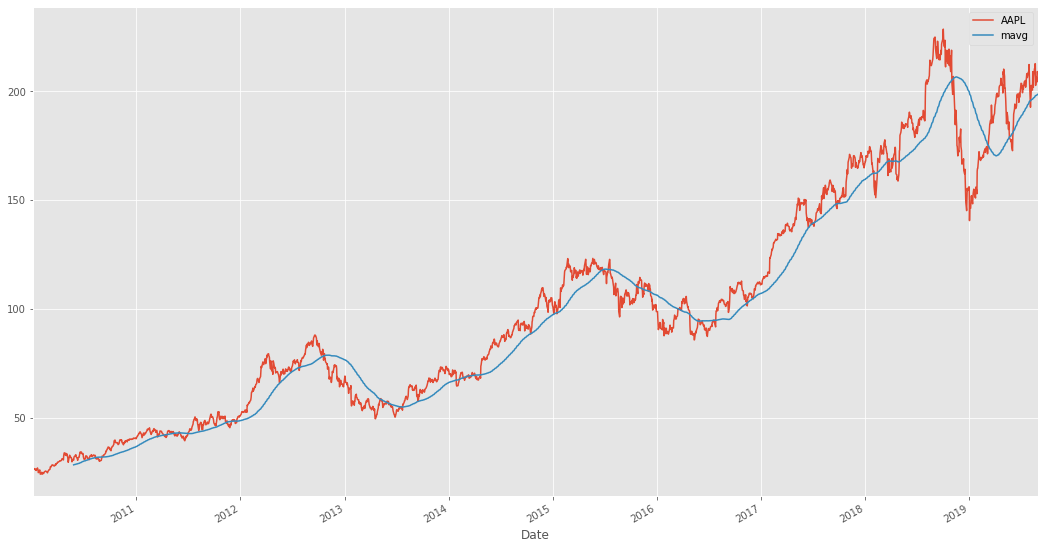

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(18, 10))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

# suljettu hinta ja 100 arvon liukuva keskiarvo

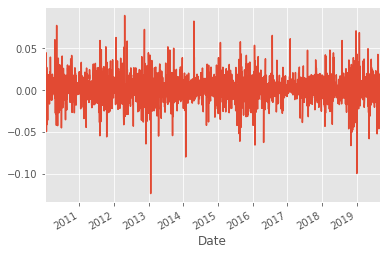

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

# paljon palauttanut tuottoa prosenttia ....

In [6]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start_date,end=end_date)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-08-26,206.490005,8.05,1168.890015,129.990005,135.449997
2019-08-27,204.160004,7.93,1167.839966,131.169998,135.740005
2019-08-28,205.529999,7.94,1171.020020,132.759995,135.559998
2019-08-29,209.009995,8.11,1192.849976,134.880005,138.119995
2019-08-30,208.740005,8.25,1188.099976,135.529999,137.860001


In [7]:

retscomp = dfcomp.pct_change()

corr = retscomp.corr()

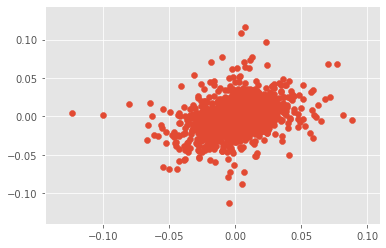

In [8]:
plt.scatter(retscomp.AAPL, retscomp.GE)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0E19A9F0>,
      dtype=object)

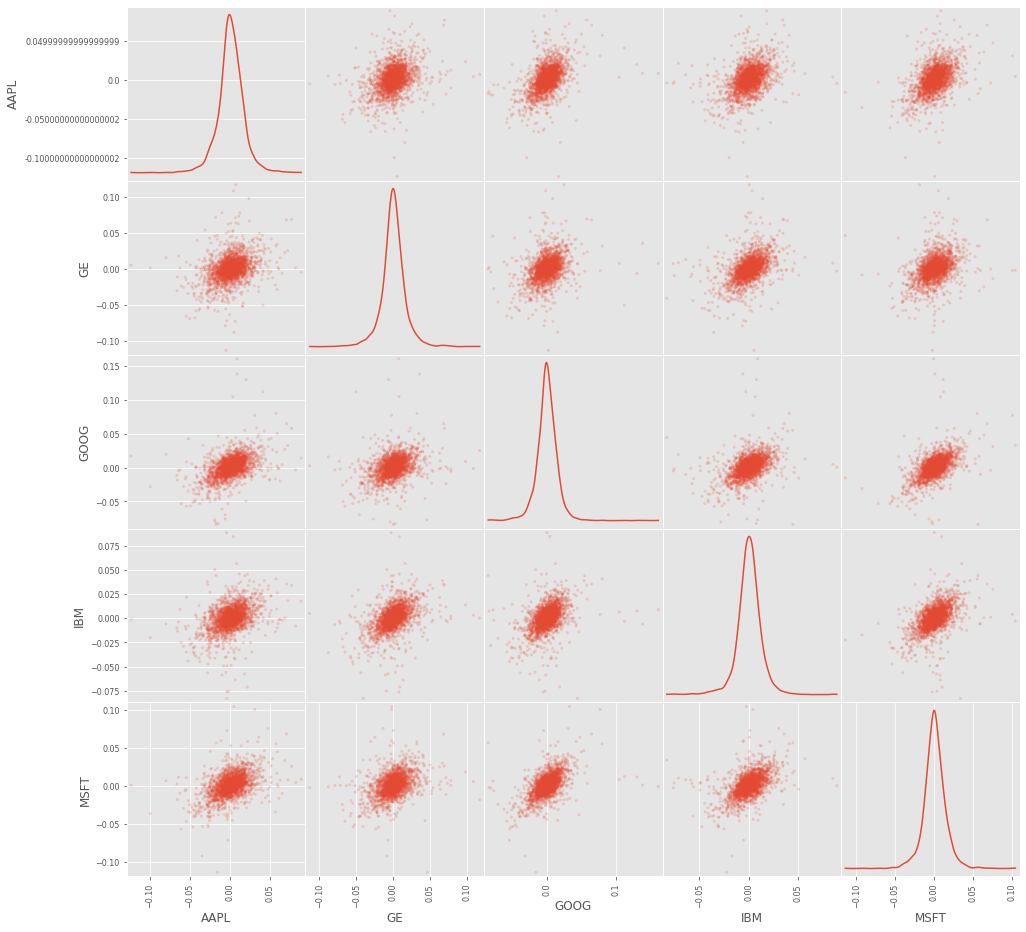

In [9]:
from pandas.plotting import scatter_matrix

pd.plotting.scatter_matrix(retscomp, diagonal='kde', alpha=0.2, figsize=(16, 16))



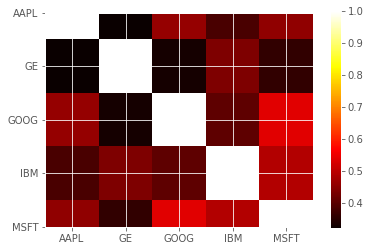

In [10]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

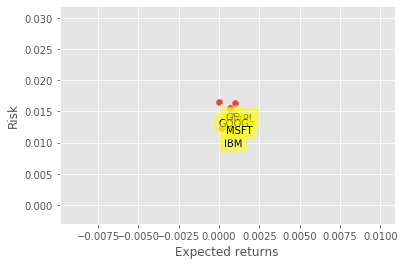

In [11]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [12]:
df.loc[:,['Adj Close','Volume']].head()

,Adj Close,Volume
Date,,
2010-01-04,26.681330,123432400.0
2010-01-05,26.727465,150476200.0
2010-01-06,26.302330,138040000.0
2010-01-07,26.253704,119282800.0
2010-01-08,26.428249,111902700.0


In [13]:
#Feature Engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


In [14]:
import math
import numpy as np
forecast_out = int(math.ceil(0.01 * len(dfreg)))
print(forecast_out)
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
#dfreg[:-forecast_out].head()
dfreg.head()
#dfreg[forecast_col].head()
#dfreg[forecast_col].shift(-forecast_out).head()



25


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2010-01-04,26.681330,123432400.0,0.990606,0.271752
2010-01-05,26.727465,150476200.0,1.091520,-0.102519
2010-01-06,26.302330,138040000.0,2.123523,-1.590633
2010-01-07,26.253704,119282800.0,1.400893,-0.552538
2010-01-08,26.428249,111902700.0,1.386924,0.798864


In [15]:
from sklearn import preprocessing



forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

X_lately = X[-forecast_out:]






In [16]:

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]



(2432, 5)


In [17]:
import math

from sklearn.model_selection import train_test_split




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
# Import models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline



In [19]:


# Linear regression 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [20]:
confidencereg = clfreg.score(X_test, y_test)

confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# Select how predict

In [21]:
forecast_set = clfreg.predict(X_lately)

[208.87391966 207.60582053 211.0011371  207.07177458 202.88752734
 192.18705264 196.33074577 198.67342945 202.94336249 201.17604879
 200.76026756 209.24780981 202.51860135 201.92200118 206.51631429
 210.17342189 210.11861361 212.42549053 212.34540218 202.40104608
 206.3804776  204.173935   205.84152088 209.02148035 208.71433656] 25


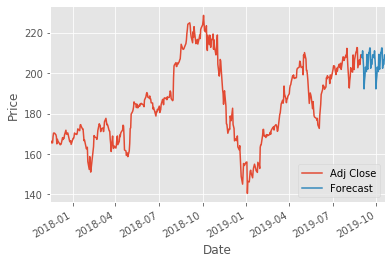

In [22]:

dfreg['Forecast'] = np.nan
print(forecast_set,  forecast_out)

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

    last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()